# 1. Importing Libraries  


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B0
from tensorflow.keras import layers, models, optimizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import nbformat
import os
import random

2025-12-01 22:18:15.709246: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 22:18:15.803972: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 22:18:17.419857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
data_dir = "Fruit And Vegetable Diseases Dataset/"

# 2.Class Distribution and Random Sample Visualization


In [5]:
class_names =sorted(os.listdir(data_dir))
n_classes = len(class_names)
class_dis = [len(os.listdir(data_dir + i)) for i in class_names]
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 28 
Class Names : ['Apple__Healthy', 'Apple__Rotten', 'Banana__Healthy', 'Banana__Rotten', 'Bellpepper__Healthy', 'Bellpepper__Rotten', 'Carrot__Healthy', 'Carrot__Rotten', 'Cucumber__Healthy', 'Cucumber__Rotten', 'Grape__Healthy', 'Grape__Rotten', 'Guava__Healthy', 'Guava__Rotten', 'Jujube__Healthy', 'Jujube__Rotten', 'Mango__Healthy', 'Mango__Rotten', 'Orange__Healthy', 'Orange__Rotten', 'Pomegranate__Healthy', 'Pomegranate__Rotten', 'Potato__Healthy', 'Potato__Rotten', 'Strawberry__Healthy', 'Strawberry__Rotten', 'Tomato__Healthy', 'Tomato__Rotten']


In [6]:
fig = px.pie(names = class_names , values = class_dis, 
             title="Training class Distribution",hole = 0.2)
fig.update_layout({'title':{'x':0.48}})
fig.show()

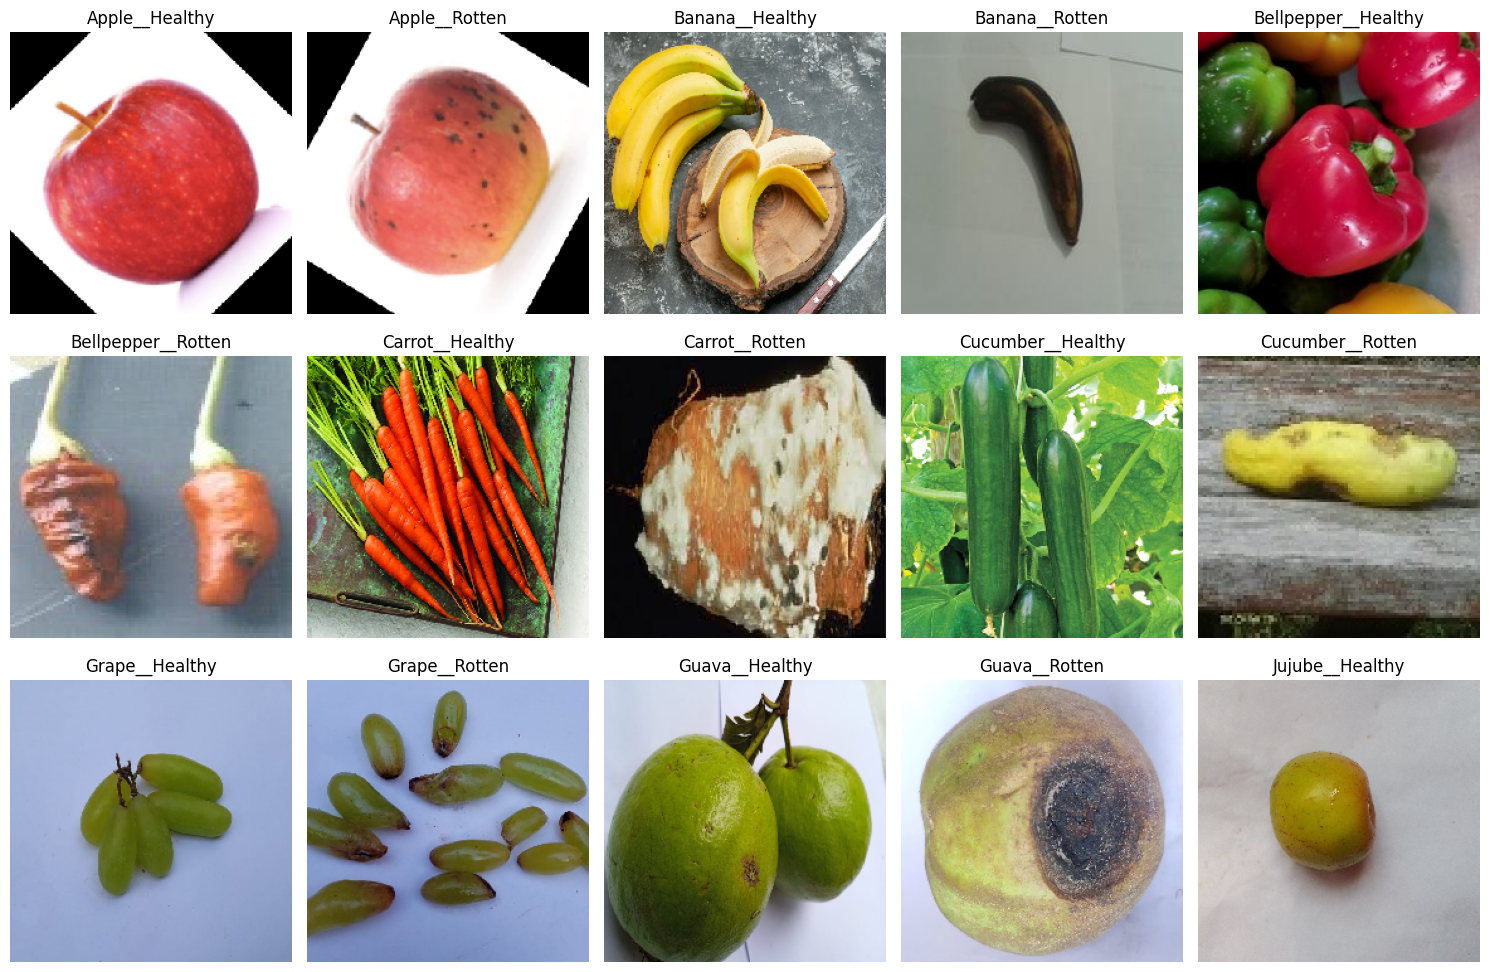

In [7]:
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names[:15]):  
    class_path = os.path.join(data_dir, class_name)
    
    image_file = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_file)

    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize

    plt.subplot(3, 5, i + 1)
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(class_name)

plt.tight_layout()
plt.show()


# 3.Data Preparation: Creating Training and Validation Sets


In [8]:
"""
rotation_range=30,
width_shift_range=0.3,
height_shift_range=0.3,
shear_range=0.3,
zoom_range=0.3,
brightness_range=[0.7, 1.3],
horizontal_flip=True,
vertical_flip=True, 
fill_mode='nearest',
"""

"\nrotation_range=30,\nwidth_shift_range=0.3,\nheight_shift_range=0.3,\nshear_range=0.3,\nzoom_range=0.3,\nbrightness_range=[0.7, 1.3],\nhorizontal_flip=True,\nvertical_flip=True, \nfill_mode='nearest',\n"

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

In [10]:
batch_size = 64
img_size = (224, 224)

In [11]:
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset="training"
)

valid_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset="validation"
)

Found 21967 images belonging to 28 classes.
Found 7310 images belonging to 28 classes.


In [12]:
print(f"Classes: {train_data.class_indices}")
print(f"Train samples: {train_data.samples}, Valid samples: {valid_data.samples}")

Classes: {'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27}
Train samples: 21967, Valid samples: 7310


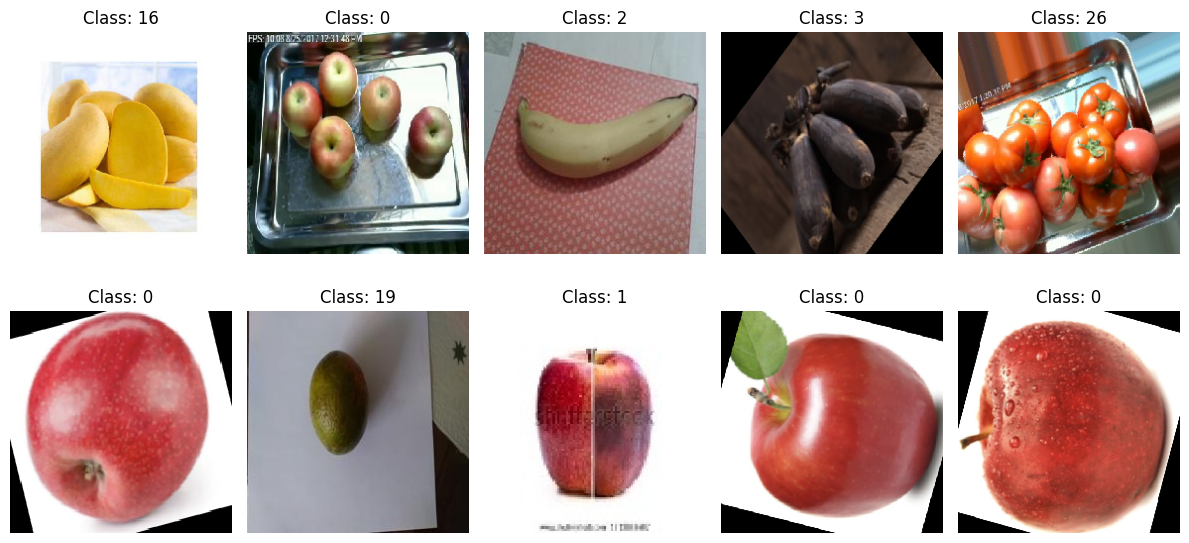

In [13]:
images, labels = next(train_data)

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i]) 
    plt.axis("off") 
    plt.title(f"Class: {np.argmax(labels[i])}")

plt.tight_layout()
plt.show()


# 4. Building the EfficientNetV2B0 Model 🚀


In [14]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
    include_preprocessing=True)


I0000 00:00:1764602303.765180     902 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [15]:
base_model.trainable = False


#base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))

x = base_model(inputs)

x = layers.Dropout(0.1)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x) 
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(28, activation='softmax')(x)
efficientnet_model = models.Model(inputs, outputs)

optimizer = optimizers.AdamW(learning_rate=1e-3) 

efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

efficientnet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,087,404 (23.22 MB)

 Trainable params: 167,836 (655.61 KB)

 Non-trainable params: 5,919,568 (22.58 MB)

In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 4.2  Pre-Fine-Tuning Training for EfficientNetV2B0 🛠️


In [17]:
history_efficientnet = efficientnet_model.fit(
    train_data,
    epochs=5,
    validation_data=valid_data 
)

Epoch 1/5


2025-12-01 22:18:35.571228: I external/local_xla/xla/service/service.cc:163] XLA service 0x7e615c004200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-01 22:18:35.571253: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-12-01 22:18:35.780870: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-01 22:18:36.882960: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-12-01 22:18:37.658247: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-01 22:18:37.658316: I e

 12/344 ━━━━━━━━━━━━━━━━━━━━ 1:28 267ms/step - accuracy: 0.0486 - loss: 3.8631

2025-12-01 22:19:02.870234: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 22:19:03.044520: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 22:19:04.015679: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 22:19:04.214316: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


213/344 ━━━━━━━━━━━━━━━━━━━━ 44s 336ms/step - accuracy: 0.0840 - loss: 3.5683

/home/masa737/ffc2/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.0937 - loss: 3.4684

2025-12-01 22:21:22.315312: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 22:21:22.489087: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 22:21:23.407137: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 22:21:23.603433: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


344/344 ━━━━━━━━━━━━━━━━━━━━ 180s 445ms/step - accuracy: 0.1144 - loss: 3.2583 - val_accuracy: 0.1090 - val_loss: 3.1561
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 128s 372ms/step - accuracy: 0.1360 - loss: 3.0151 - val_accuracy: 0.0934 - val_loss: 3.1230
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 123s 359ms/step - accuracy: 0.1367 - loss: 2.9609 - val_accuracy: 0.0204 - val_loss: 12.3520
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 123s 358ms/step - accuracy: 0.1408 - loss: 2.9342 - val_accuracy: 0.0780 - val_loss: 3.1674
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 114s 332ms/step - accuracy: 0.1388 - loss: 2.9277 - val_accuracy: 0.1369 - val_loss: 2.9965


In [18]:
base_model.trainable = True

optimizer = optimizers.AdamW(learning_rate=1e-4)  

efficientnet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

efficientnet_model.fit(train_data, validation_data=valid_data, epochs=5)


Epoch 1/5


2025-12-01 22:30:11.498874: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 22:30:11.673250: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 22:30:21.650387: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 22:30:21.831797: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


169/344 ━━━━━━━━━━━━━━━━━━━━ 42s 243ms/step - accuracy: 0.4886 - loss: 1.9563

2025-12-01 22:31:28.629109: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-01 22:31:28.809126: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


344/344 ━━━━━━━━━━━━━━━━━━━━ 221s 450ms/step - accuracy: 0.7853 - loss: 0.9269 - val_accuracy: 0.8633 - val_loss: 0.6110
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 134s 390ms/step - accuracy: 0.9522 - loss: 0.2812 - val_accuracy: 0.7465 - val_loss: 0.9674
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 122s 353ms/step - accuracy: 0.9746 - loss: 0.1723 - val_accuracy: 0.7245 - val_loss: 1.0242
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 128s 371ms/step - accuracy: 0.9867 - loss: 0.1205 - val_accuracy: 0.8462 - val_loss: 0.5740
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 124s 360ms/step - accuracy: 0.9907 - loss: 0.0943 - val_accuracy: 0.9267 - val_loss: 0.3165


In [19]:
loss, accuracy = efficientnet_model.evaluate(valid_data)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 30s 261ms/step - accuracy: 0.9267 - loss: 0.3165
Validation Accuracy: 0.9267
Validation Loss: 0.3165


## 5. Result


2025-12-01 22:42:25.573812: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv (f32[32,576,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,576,14,14]{3,2,1,0}, f32[576,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-12-01 22:42:25.766596: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 3.796871782s
Trying algorithm eng3{k11=2} for conv (f32[32,576,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,576,14,14]{3,2,1,0}, f32[576,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step


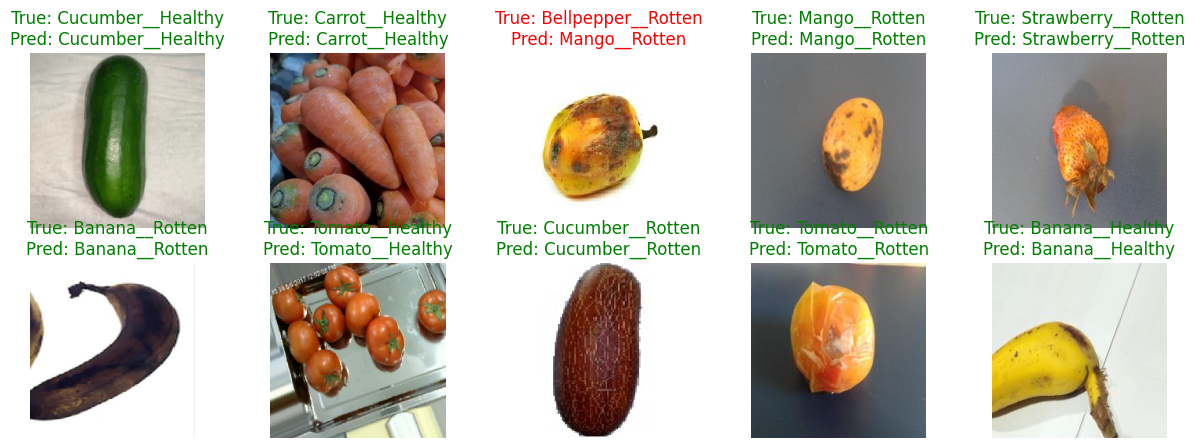

In [20]:
valid_data.reset()
images, labels = next(valid_data)

predictions = efficientnet_model.predict(images)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

plt.figure(figsize=(15, 5))
for i in range(10): 
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label = list(valid_data.class_indices.keys())[true_classes[i]]
    pred_label = list(valid_data.class_indices.keys())[predicted_classes[i]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


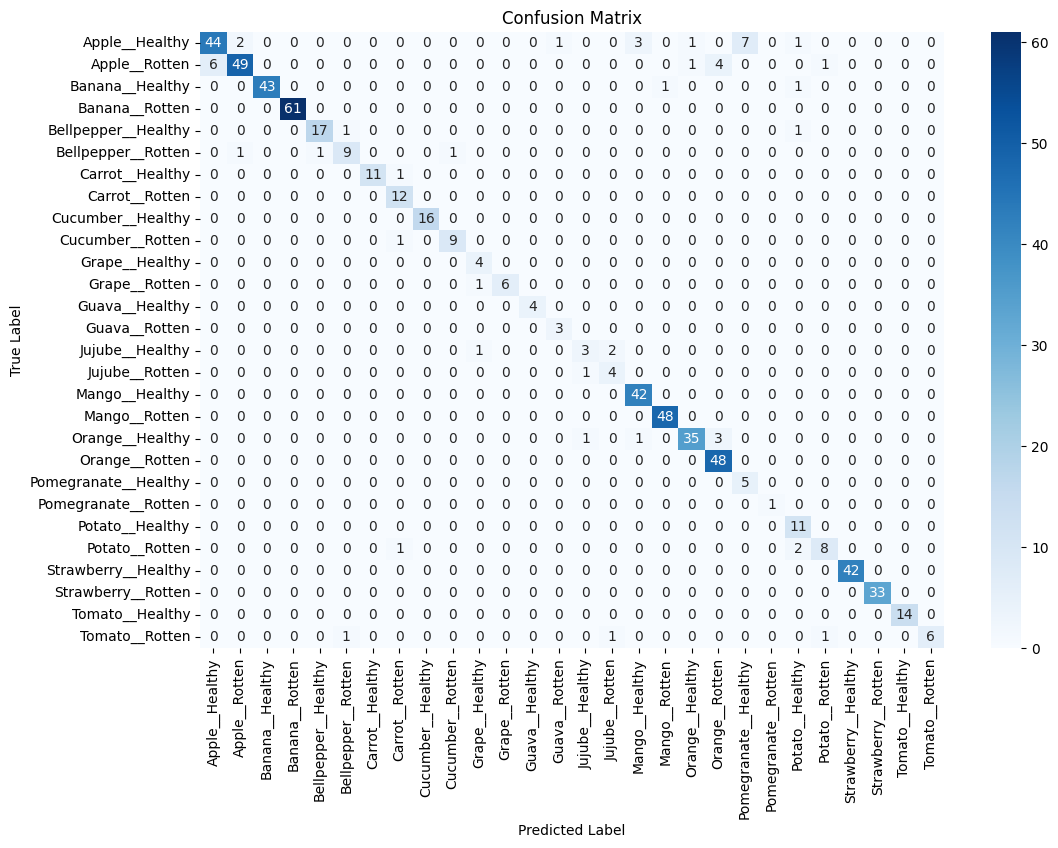

                      precision    recall  f1-score   support

      Apple__Healthy       0.88      0.75      0.81        59
       Apple__Rotten       0.94      0.80      0.87        61
     Banana__Healthy       1.00      0.96      0.98        45
      Banana__Rotten       1.00      1.00      1.00        61
 Bellpepper__Healthy       0.94      0.89      0.92        19
  Bellpepper__Rotten       0.82      0.75      0.78        12
     Carrot__Healthy       1.00      0.92      0.96        12
      Carrot__Rotten       0.80      1.00      0.89        12
   Cucumber__Healthy       1.00      1.00      1.00        16
    Cucumber__Rotten       0.90      0.90      0.90        10
      Grape__Healthy       0.67      1.00      0.80         4
       Grape__Rotten       1.00      0.86      0.92         7
      Guava__Healthy       1.00      1.00      1.00         4
       Guava__Rotten       0.75      1.00      0.86         3
     Jujube__Healthy       0.60      0.50      0.55         6
      J

In [21]:
num_batches = 10 

y_pred_probs = []
y_true = []

for i, (images, labels) in enumerate(valid_data):
    if i >= num_batches: 
        break
    preds = efficientnet_model.predict(images)
    y_pred_probs.append(preds)
    y_true.append(labels)

y_pred_probs = np.concatenate(y_pred_probs, axis=0)
y_true = np.concatenate(y_true, axis=0)

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [22]:
errors_per_class = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
error_rate_per_class = errors_per_class / np.sum(conf_matrix, axis=1)

sorted_errors = sorted(zip(class_names, error_rate_per_class), key=lambda x: x[1], reverse=True)
print("📌 Classes with the Highest Error Rate:")
for cls, error in sorted_errors[:5]: 
    print(f"{cls}: {error:.2%} error")


📌 Classes with the Highest Error Rate:
Jujube__Healthy: 50.00% error
Tomato__Rotten: 33.33% error
Potato__Rotten: 27.27% error
Apple__Healthy: 25.42% error
Bellpepper__Rotten: 25.00% error


In [23]:
import os
import json

os.makedirs("saved_models", exist_ok=True)

efficientnet_model.save("saved_models/efficientnetv2_b0.h5")  


class_indices = train_data.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
with open("saved_models/class_indices.json", "w") as f:
    json.dump(inv_class_indices, f)
print("Saved models and class mapping to saved_models/")

Saved models and class mapping to saved_models/


----------------------